In [3]:
# Librairies :
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


In [2]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 3.2 MB/s eta 0:00:00a 0:00:01


In [71]:
# Import des données :
training_data = pd.read_csv("training_clean.csv")
#df_pricing = pd.read_csv("pricing.csv")

training_data.head()

,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


## RE-traitement de donnée 

In [72]:
training_data.Numtpbi.value_counts()

Numtpbi
0    95476
1     4335
2      162
3        6
Name: count, dtype: int64

In [73]:
training_data=training_data.iloc[21:]


In [74]:
bins = [18, 25, 40, 60, 100]  # Adaptez ces valeurs selon vos observations spécifiques
labels = ['18-24', '25-39', '40-59', '60+']  # Les labels correspondent aux tranches d'âge

# Utilisez pd.cut pour binariser la colonne 'Age'
training_data['AgeGroup'] = pd.cut(training_data['Age'], bins=bins, labels=labels, right=False)
training_data['Age_Bonus'] = training_data['Age'] * training_data['Bonus']

# Vérifiez le résultat
training_data[['Age', 'AgeGroup']].head()
# Groupez par 'AgeGroup' et puis appliquez 'value_counts' sur 'Numtpbi'
grouped_counts = training_data.groupby('AgeGroup')['Numtpbi'].value_counts().unstack(fill_value=0)

# Affichez le résultat
print(grouped_counts)

Numtpbi       0     1   2  3
AgeGroup                    
18-24     11924  1209  76  2
25-39     34538  1695  56  2
40-59     36733  1160  27  2
60+       12262   269   3  0


/tmp/ipykernel_418/2469090517.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = training_data.groupby('AgeGroup')['Numtpbi'].value_counts().unstack(fill_value=0)


In [75]:
training_data.Numtpbi.value_counts()

Numtpbi
0    95457
1     4333
2      162
3        6
Name: count, dtype: int64

In [76]:
training_data = training_data[training_data['Numtpbi'] != 3]
training_data.Numtpbi.value_counts()

Numtpbi
0    95457
1     4333
2      162
Name: count, dtype: int64

In [77]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99952 entries, 21 to 99978
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PolNum      99952 non-null  int64   
 1   CalYear     99952 non-null  int64   
 2   Gender      99952 non-null  object  
 3   Type        99952 non-null  object  
 4   Category    99952 non-null  object  
 5   Occupation  99952 non-null  object  
 6   Age         99952 non-null  int64   
 7   Group1      99952 non-null  int64   
 8   Bonus       99952 non-null  int64   
 9   Poldur      99952 non-null  int64   
 10  Value       99952 non-null  float64 
 11  Adind       99952 non-null  int64   
 12  SubGroup2   99952 non-null  object  
 13  Group2      99952 non-null  object  
 14  Density     99952 non-null  float64 
 15  Exppdays    99952 non-null  float64 
 16  Numtppd     99952 non-null  int64   
 17  Numtpbi     99952 non-null  int64   
 18  Indtppd     99952 non-null  float64 
 19  Indtpbi 

### Choix des variables 

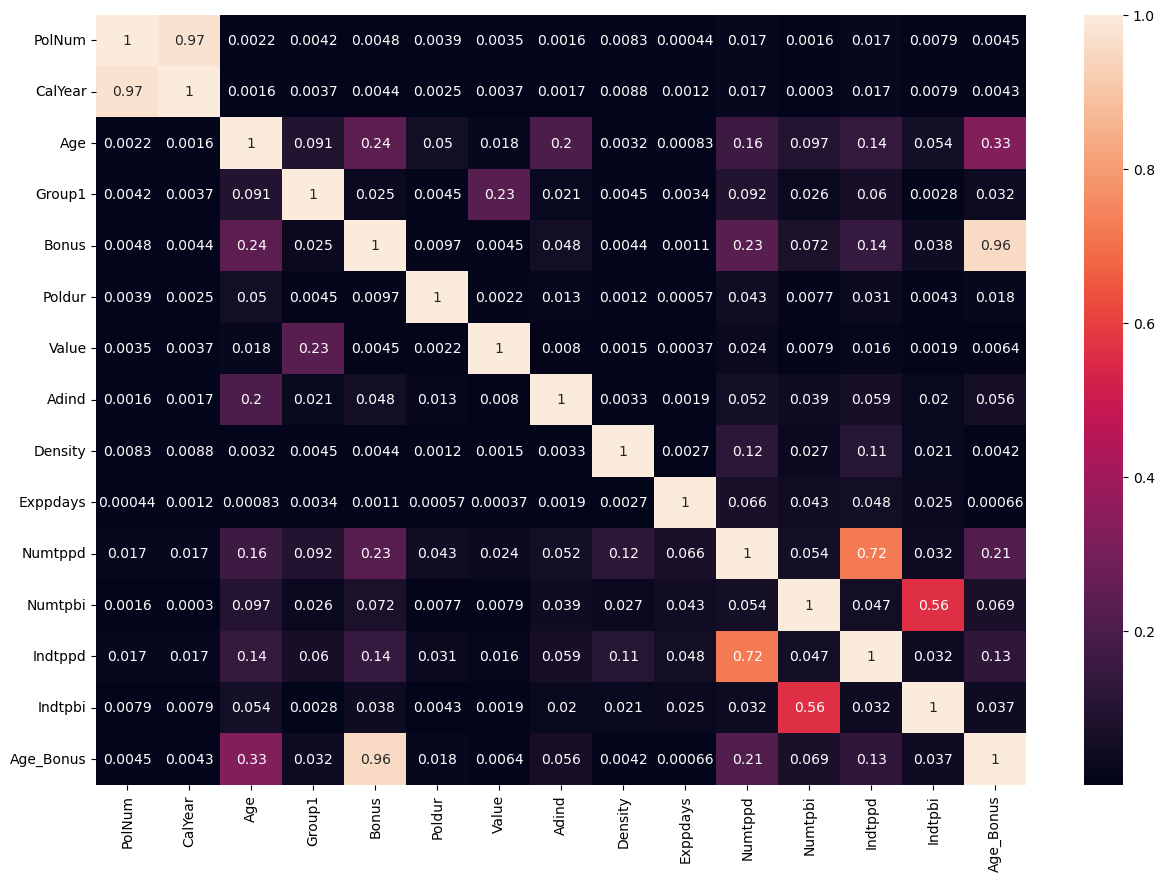

In [78]:
#Correlation
numeric_cols = training_data.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr().abs(), annot=True)
plt.show()

In [79]:

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2','AgeGroup']
target_variable = 'Numtpbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Numtpbi: p-value = 0.003002883785207551
Cramer's V for Gender and Numtpbi: 0.010780511543144456
Chi-squared test result for Type and Numtpbi: p-value = 0.5510848800042208
Cramer's V for Type and Numtpbi: 0.009383633876387323
Chi-squared test result for Category and Numtpbi: p-value = 1.8369282051599697e-32
Cramer's V for Category and Numtpbi: 0.03936346290649378
Chi-squared test result for Occupation and Numtpbi: p-value = 6.506379762749964e-93
Cramer's V for Occupation and Numtpbi: 0.06736018327391682
Chi-squared test result for Group2 and Numtpbi: p-value = 7.699516100095994e-07
Cramer's V for Group2 and Numtpbi: 0.02502770829349212
Chi-squared test result for AgeGroup and Numtpbi: p-value = 3.3340080083334544e-261
Cramer's V for AgeGroup and Numtpbi: 0.11065330523746823


## Modèle 

In [80]:
X = training_data[[ 'Gender', 'Occupation', 'Age', 'Bonus', 'Poldur', 'Exppdays','Indtpbi','Age_Bonus','Indtppd', 'Numtppd']]

y = training_data['Numtpbi' ]

In [81]:
# Creation of categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [45]:

# Handling missing data and normalization of numeric data with MaxAbsScaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", MaxAbsScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

In [46]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


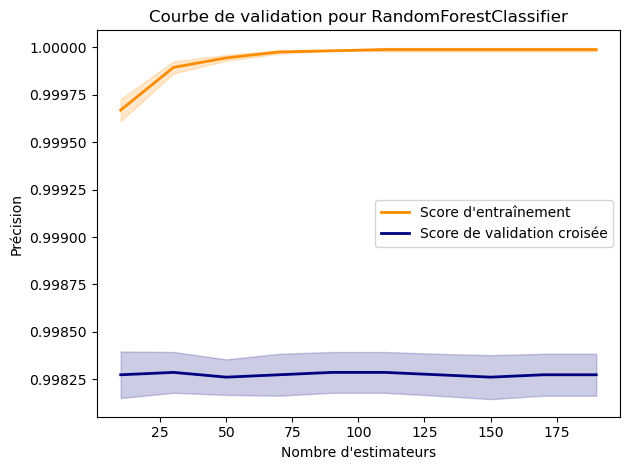

In [294]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Initialisation du classificateur
clf = RandomForestClassifier(random_state=42)

# Définir la plage des valeurs à tester pour 'n_estimators'
param_range = np.arange(10, 200, 20)

# Calculer les scores de validation pour chaque valeur du paramètre
train_scores, test_scores = validation_curve(
    clf, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=3, scoring="accuracy", n_jobs=-1)

# Calculer la moyenne et l'écart-type pour les scores d'entraînement
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculer la moyenne et l'écart-type pour les scores de test
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Afficher les courbes
plt.plot(param_range, train_mean, label="Score d'entraînement", color="darkorange", lw=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)
plt.plot(param_range, test_mean, label="Score de validation croisée", color="navy", lw=2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Courbe de validation pour RandomForestClassifier")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Précision")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


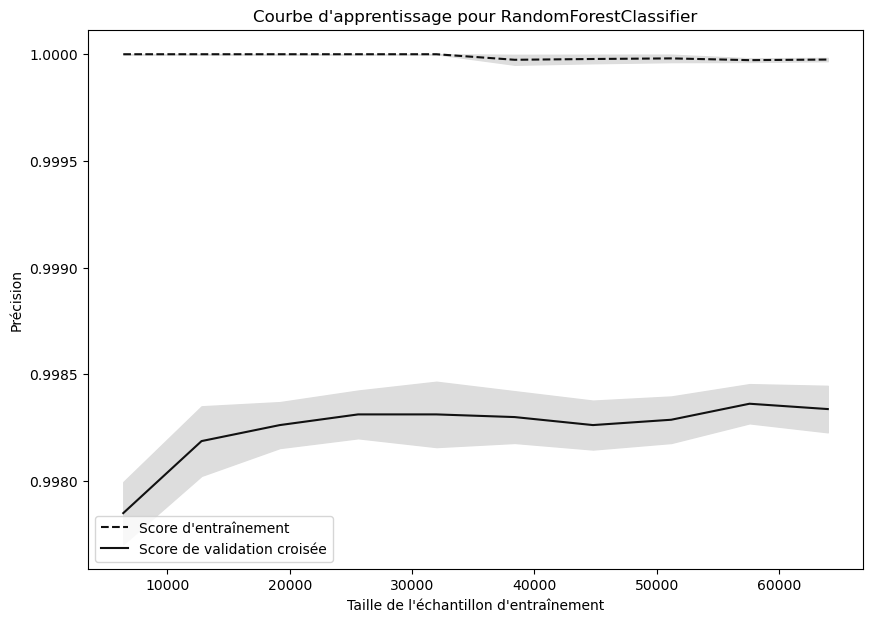

In [295]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Choisissez le modèle pour lequel vous souhaitez tracer la courbe d'apprentissage
model = RandomForestClassifier(random_state=42, n_estimators=100)

# Définir les tailles des échantillons d'entraînement pour calculer la courbe d'apprentissage
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X_train, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points linéairement espacés de 10% à 100%
    cv=5,  # Validation croisée à 5 folds
    scoring='accuracy', 
    n_jobs=-1  # Utiliser tous les processeurs disponibles
)

# Calculer la moyenne et l'écart-type des scores d'entraînement
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculer la moyenne et l'écart-type des scores de validation
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Tracer les courbes
plt.subplots(1, 1, figsize=(10, 7))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Score d'entraînement")
plt.plot(train_sizes, validation_mean, color="#111111", label="Score de validation croisée")

# Tracer les bandes de variation pour l'entraînement
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")

# Tracer les bandes de variation pour la validation
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")

# Ajouter les titres et les légendes
plt.title("Courbe d'apprentissage pour RandomForestClassifier")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.legend(loc="best")

# Afficher le graphique
plt.show()


## RF

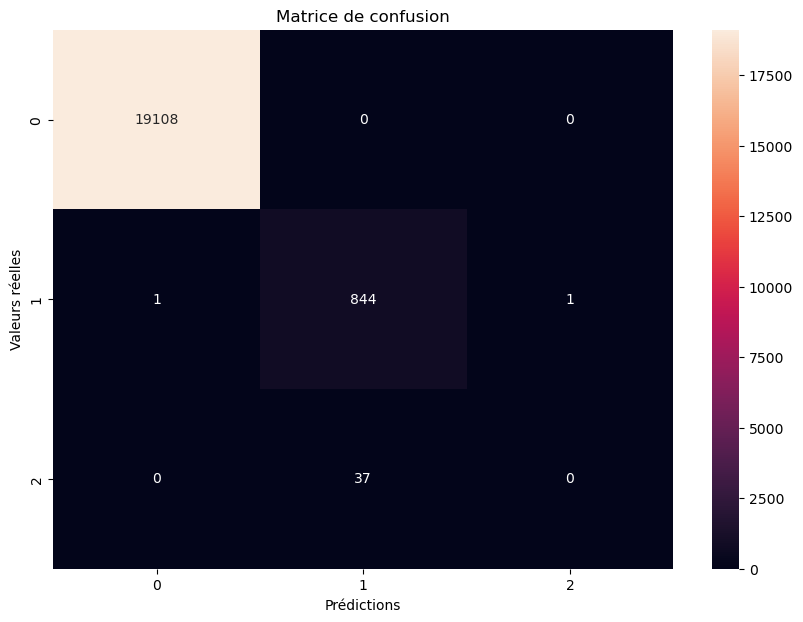

In [79]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_predrfs = clf.predict(X_test)



# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

## RF SMOTE

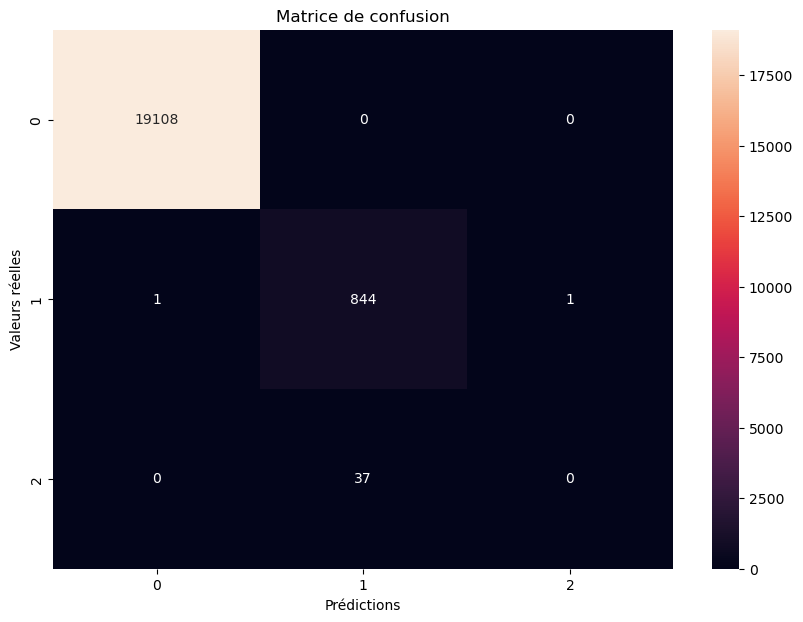

In [80]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Prédiction sur l'ensemble de test
y_predrfs= clf.predict(X_test)


# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19160
           1       0.98      0.97      0.97       814
           2       0.04      0.05      0.04        21

    accuracy                           1.00     19995
   macro avg       0.67      0.67      0.67     19995
weighted avg       1.00      1.00      1.00     19995



## XGBOOST SMOTE

In [81]:
import xgboost as xgb
#Create an XGBoost Classifier model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_smote, y_train_smote)

# Use the best estimator to make predictions
y_pred_xgbst = xgb_model.predict(X_test)

# Evaluate the model
#print("Classification Report:")
print(classification_report(y_test, y_pred_xgbst ))


 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19108
           1       0.95      0.92      0.94       846
           2       0.07      0.05      0.06        37

    accuracy                           0.99     19991
   macro avg       0.68      0.66      0.67     19991
weighted avg       0.99      0.99      0.99     19991



In [82]:
conf_matrix = confusion_matrix(y_test, y_pred_xgbst)
print("Matrice de confusion :")
print(conf_matrix)


Matrice de confusion :
[[19106     2     0]
 [   40   781    25]
 [    0    35     2]]


In [83]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
}

grid_search_xgbst = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search_xgbst.fit(X_train_smote, y_train_smote)
 
print(grid_search_xgbst.best_params_)
best_model = grid_search_xgbst.best_estimator_
y_pred_xgb = best_model.predict(X_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 150}


In [84]:
cm_xgb = confusion_matrix(y_test, y_pred)
cm_xgb

array([[19108,     0,     0],
       [    1,   844,     1],
       [    0,    37,     0]])

### ADASYN

In [85]:
from collections import Counter
from imblearn.over_sampling import ADASYN

# Création de l'objet ADASYN et suréchantillonnage des données d'entraînement
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Vérifiez la distribution des classes après ADASYN
print("Distribution des classes après ADASYN:", sorted(Counter(y_train_adasyn).items()))



Distribution des classes après ADASYN: [(0, 76349), (1, 77672), (2, 76379)]


### RF ADASYN

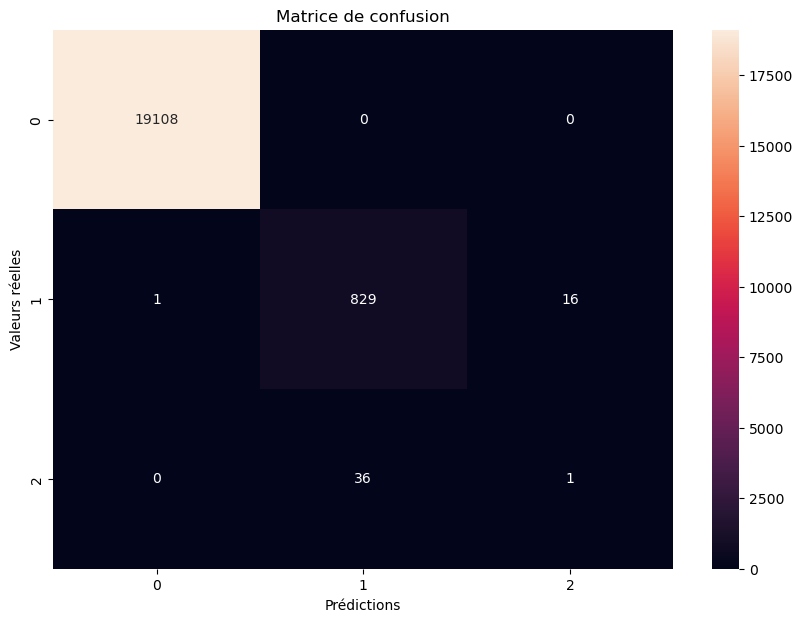

In [86]:

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_adasyn, y_train_adasyn)

# Prédiction sur l'ensemble de test
y_pred = clf.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19108
           1       0.96      0.98      0.97       846
           2       0.06      0.03      0.04        37

    accuracy                           1.00     19991
   macro avg       0.67      0.67      0.67     19991
weighted avg       1.00      1.00      1.00     19991



In [90]:
from sklearn.metrics import f1_score
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 score pour chaque classe :", f1_scores)


F1 score pour chaque classe : [0.99997383 0.96902396 0.03703704]


### RF ADASYN randomized

In [222]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Définissez votre modèle
model = RandomForestClassifier(random_state=42)

# Définissez la distribution des hyperparamètres à tester
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Configurez la recherche aléatoire
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Entraînez votre modèle en utilisant la recherche aléatoire
random_search.fit(X_train_adasyn, y_train_adasyn)

# Affichez les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)

# Utilisez le meilleur modèle pour faire des prédictions
best_model = random_search.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149}


In [166]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision (Accuracy) sur l'ensemble de test: {accuracy:.4f}")

# Générer et afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)



Précision (Accuracy) sur l'ensemble de test: 0.9974
Matrice de confusion :
[[19160     0     0]
 [    1   782    31]
 [    0    20     1]]


## SMOTE et ADASYN

In [218]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate



# Créer un pipeline qui combine suréchantillonnage et classification
pipeline = make_pipeline(SMOTE(), ADASYN(), RandomForestClassifier())

# Effectuer une validation croisée avec suréchantillonnage intégré
scores = cross_validate(pipeline, X_train, y_train, scoring='f1_macro', cv=StratifiedKFold(n_splits=5))

# Afficher les scores F1 pour chaque pli
print(scores['test_score'])

# Afficher le score F1 moyen sur tous les plis
print(scores['test_score'].mean())

[0.68148412 0.69428426 0.68694044 0.71035138 0.69709961]
0.6940319629075875


In [219]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import numpy as np

# Préparation des données (supposons que X et y soient déjà définis
# Création d'un pipeline
pipeline = make_pipeline(SMOTE(), ADASYN(), XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))

# Configuration de la validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcul des scores F1 pour chaque pli
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=skf)

# Affichage des résultats
print("Scores F1 pour chaque pli :", scores)
print("Score F1 moyen :", np.mean(scores))


Scores F1 pour chaque pli : [0.67398861 0.70340938 0.69434633 0.67433152 0.68997435]
Score F1 moyen : 0.6872100371882157


## Resample

In [103]:
from sklearn.utils import resample
    
# Filtrer les différentes classes
df_class_0 = training_data[training_data['Numtpbi'] == 0]
df_class_1 = training_data[training_data['Numtpbi'] == 1]
df_class_2 = training_data[training_data['Numtpbi'] == 2]

# Sous-échantillonnage des classes 0 et 1 à 1000 échantillons chacune
df_class_0_sampled = resample(df_class_0, replace=False, n_samples=500, random_state=42)
df_class_1_sampled = resample(df_class_1, replace=False, n_samples=500, random_state=42)

# Combinez les échantillons sous-échantillonnés avec tous les échantillons de la classe 2
df_balanced = pd.concat([df_class_0_sampled, df_class_1_sampled, df_class_2])

# Préparer les caractéristiques et la cible
X = df_balanced[[ 'Gender', 'Occupation', 'Poldur', 'Exppdays','Indtpbi','Age_Bonus']]
y = df_balanced['Numtpbi']
 



In [104]:
# Creation of categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns
# Handling missing data and normalization of numeric data with MaxAbsScaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", MaxAbsScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [105]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## RF

In [106]:
# Entraîner un modèle de forêt aléatoire
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.84      0.80      0.82       106
           2       0.36      0.43      0.39        28

    accuracy                           0.84       233
   macro avg       0.74      0.74      0.74       233
weighted avg       0.85      0.84      0.85       233

[[99  0  0]
 [ 0 85 21]
 [ 0 16 12]]


In [107]:
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 score pour chaque classe :", f1_scores)

F1 score pour chaque classe : [1.         0.82125604 0.39344262]


In [108]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the parameter grid for grid search
param_grid_1 = {
    'n_estimators': [100, 200, 300, 400],  # Increased number of estimators
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 10, 12],  # Increased range for max_depth
    'min_samples_split': [2, 5, 10],  # Added min_samples_split to control overfitting
    'min_samples_leaf': [1, 2, 4],  # Added min_samples_leaf to control overfitting
    'criterion' :['gini', 'entropy']
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_1, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search_rf.fit(X_train_smote, y_train_smote)
 

# Use the best estimator to make predictions
y_predrfg = grid_search_rf.predict(X_test)

# Evaluate the model
#print("Classification Report:")
print(classification_report(y_test, y_predrfg))
rfg_accuracy = accuracy_score(y_test, y_predrfg)
from sklearn.metrics import f1_score
f1_scores = f1_score(y_test, y_predrfg, average=None)
print("F1 score pour chaque classe :", f1_scores)

/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
441 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/mamba/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/opt/mamba/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/mamba/lib/python3.11/site-packages/sklearn/ut

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.85      0.78      0.81       106
           2       0.36      0.46      0.41        28

    accuracy                           0.84       233
   macro avg       0.74      0.75      0.74       233
weighted avg       0.85      0.84      0.84       233

F1 score pour chaque classe : [1.         0.81372549 0.40625   ]


In [109]:

# Évaluer le modèle
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_predrfg))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.84      0.80      0.82       106
           2       0.36      0.43      0.39        28

    accuracy                           0.84       233
   macro avg       0.74      0.74      0.74       233
weighted avg       0.85      0.84      0.85       233

[[99  0  0]
 [ 0 83 23]
 [ 0 15 13]]


## XGBoost

In [110]:
#XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create GridSearchCV object
grid_search_xgbst = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search_xgbst.fit(X_train_smote, y_train_smote)
y_pred_xgbstg = grid_search_xgbst.predict(X_test)

 
# Print the best parameters and the best score
#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)


# Evaluate the model
#print("Classification Report:")
print(classification_report(y_test, y_pred_xgbstg ))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.83      0.86      0.85       106
           2       0.40      0.36      0.38        28

    accuracy                           0.86       233
   macro avg       0.74      0.74      0.74       233
weighted avg       0.85      0.86      0.86       233



In [111]:

xgbst_f1_score = f1_score(y_test, y_pred_xgbstg, average='weighted')  # Adjusted for multiclass
print('F1 Score=', xgbst_f1_score)


F1 Score= 0.8553487995450154


### Regression logistique

In [112]:
# Grid search 
from sklearn.linear_model import LogisticRegression
grid={"C": np.logspace(-3,3,7),"penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
 
# Fit the grid search to the data
logreg_cv.fit(X_train, y_train)
 

# Use the best estimator to make predictions
y_predrlcv=logreg_cv.predict(X_test)

# Evaluate the model
#print("Classification Report:")
print(classification_report(y_test, y_predrlcv))


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        99
           1       0.73      0.65      0.69       106
           2       0.33      0.11      0.16        28

    accuracy                           0.73       233
   macro avg       0.61      0.59      0.57       233
weighted avg       0.70      0.73      0.70       233



/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [113]:

lr_f1_score = f1_score(y_test, y_predrlcv, average='weighted')  # Adjusted for multiclass
print('F1 Score=', lr_f1_score)


F1 Score= 0.7007673554319731


## SVM

In [114]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Creating a Support Vector Machine (SVM) classifier
svm_model = SVC(random_state=42)

# Training the model on the training data
svm_model.fit(X_train_smote, y_train_smote)

# Making predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluating the model
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))
 

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        99
           1       0.58      0.40      0.47       106
           2       0.31      0.39      0.35        28

    accuracy                           0.54       233
   macro avg       0.49      0.51      0.49       233
weighted avg       0.55      0.54      0.53       233



In [28]:

svm_f1_score = f1_score(y_test, y_pred_svm, average='weighted')  # Adjusted for multiclass
print('F1 Score=', svm_f1_score)


F1 Score= 0.47513279081232956


In [29]:
from sklearn.metrics import f1_score

# For micro-average
svm_f1_score_micro = f1_score(y_test, y_pred_svm, average='micro')
print('F1 Score (Micro)=', svm_f1_score_micro)

# For macro-average
svm_f1_score_macro = f1_score(y_test, y_pred_svm, average='macro')
print('F1 Score (Macro)=', svm_f1_score_macro)

# For weighted-average
svm_f1_score_weighted = f1_score(y_test, y_pred_svm, average='weighted')
print('F1 Score (Weighted)=', svm_f1_score_weighted)


F1 Score (Micro)= 0.48068669527896996
F1 Score (Macro)= 0.4544222899703132
F1 Score (Weighted)= 0.47513279081232956


In [120]:
dataProv = pd.DataFrame(y_test.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test)
dataProv['Pred_model'] = y_predrlcv
dataProv['Pred_svm'] = y_pred_svm
dataProv['Pred_rf'] = y_predrfg
dataProv['Pred_xgb'] = y_pred_xgbstg
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

,index,Obs,Pred_model,Pred_svm,Pred_rf,Pred_xgb
0,8109,0,0,0,0,0
1,95824,0,0,0,0,0
2,48598,2,1,2,2,2
3,6980,1,1,0,1,1
4,270,1,1,1,2,2


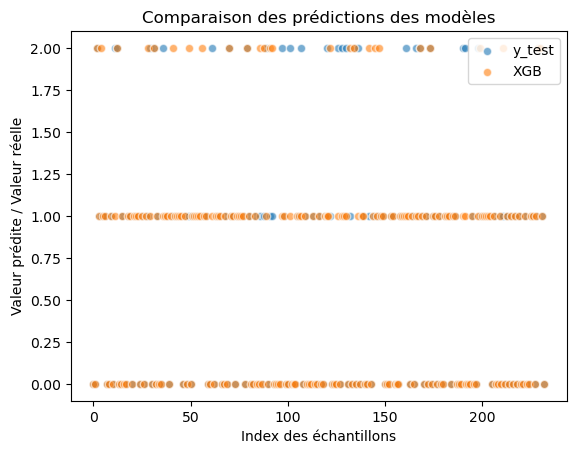

In [31]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

# Ajouter chaque série de prédictions au graphique
ax.scatter(range(len(y_test)), y_test, label='y_test', alpha=0.6, edgecolors='w')
ax.scatter(range(len(y_pred_xgbstg)), y_pred_xgbstg, label='XGB', alpha=0.6, edgecolors='w')


# Ajouter une légende
ax.legend()

# Ajouter un titre et des étiquettes aux axes
ax.set_title('Comparaison des prédictions des modèles')
ax.set_xlabel('Index des échantillons')
ax.set_ylabel('Valeur prédite / Valeur réelle')

# Afficher le graphique
plt.show()

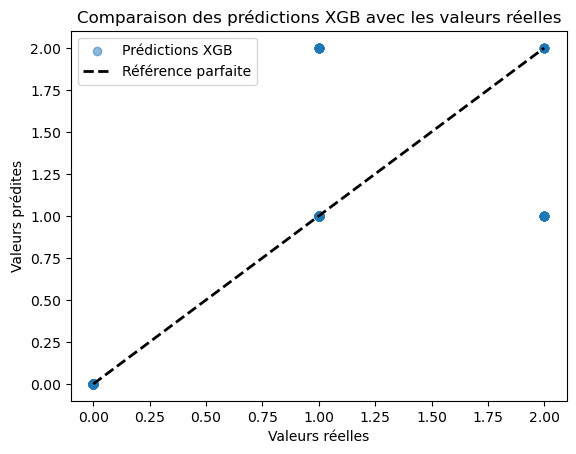

In [32]:
fig, ax = plt.subplots()

# Tracer les valeurs réelles vs les prédictions dans un nuage de points
ax.scatter(y_test, y_pred_xgbstg, alpha=0.5, label='Prédictions XGB')

# Tracer la ligne de référence parfaite
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Référence parfaite')

# Ajouter une légende
ax.legend()

# Ajouter un titre et des étiquettes aux axes
ax.set_title('Comparaison des prédictions XGB avec les valeurs réelles')
ax.set_xlabel('Valeurs réelles')
ax.set_ylabel('Valeurs prédites')

# Afficher le graphique
plt.show()

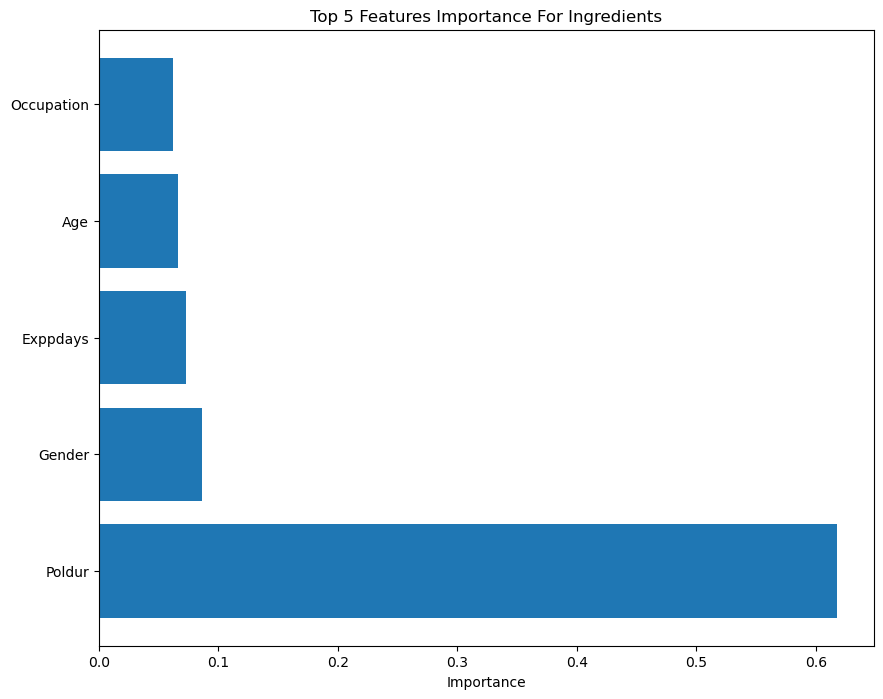

In [33]:
# Retrieve the best estimator
best_rf_model = grid_search_rf.best_estimator_
feature_importances = best_rf_model.feature_importances_

feature_names =  [ 'Gender', 'Occupation', 'Age', 'Bonus', 'Poldur', 'Exppdays','Indtpbi','Age_Bonus','Indtppd', 'Numtppd']
# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(5), feature_importances[top_5_idx], align='center')
plt.yticks(range(5), np.array(feature_names)[top_5_idx])
plt.xlabel('Importance')
plt.title('Top 5 Features Importance For Ingredients')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

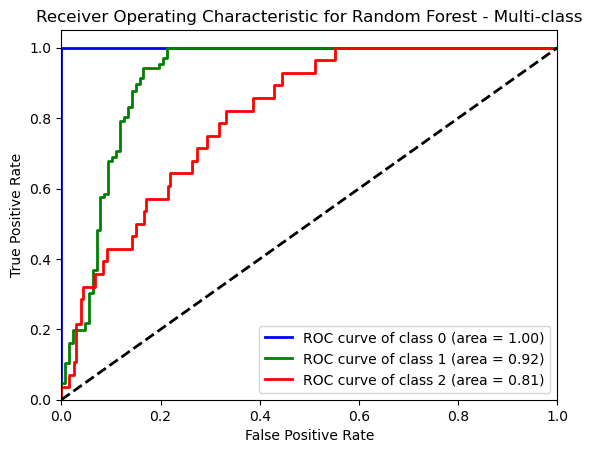

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have more than 2 classes, binarize the output labels for multi-class scenario
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Predict probabilities for each class
y_scores_rf = grid_search_rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_scores_rf.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = iter(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])
for i in range(n_classes):
    color = next(colors)
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest - Multi-class')
plt.legend(loc="lower right")
plt.show()


In [121]:
dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()

,index,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,...,Numtpbi,Indtppd,Indtpbi,AgeGroup,Age_Bonus,Obs,Pred_model,Pred_svm,Pred_rf,Pred_xgb
0,270,200115120,2009,Male,A,Small,Self-employed,18,8,0,...,1,3137.674387,3840.044532,18-24,0,1,1,1,2,2
1,635,200115485,2009,Female,D,Small,Unemployed,47,19,-30,...,0,0.000000,0.000000,40-59,-1410,0,0,1,0,0
2,669,200115519,2009,Female,C,Medium,Employed,42,6,85,...,0,0.000000,0.000000,40-59,3570,0,0,1,0,0
3,974,200115824,2009,Male,F,Medium,Self-employed,28,11,30,...,1,12.985802,607.964106,25-39,840,1,1,1,1,1
4,1051,200115902,2009,Male,A,Large,Housewife,53,17,-50,...,0,0.000000,0.000000,40-59,-2650,0,0,0,0,0


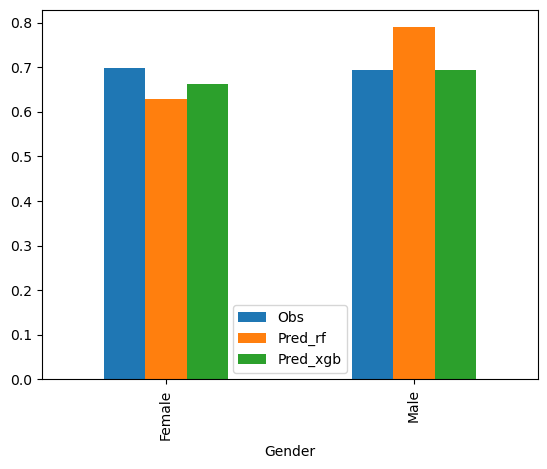

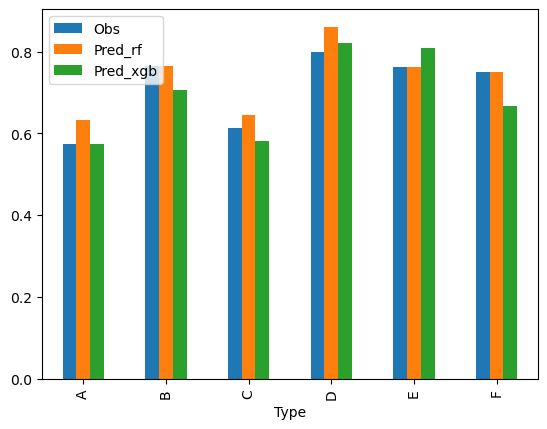

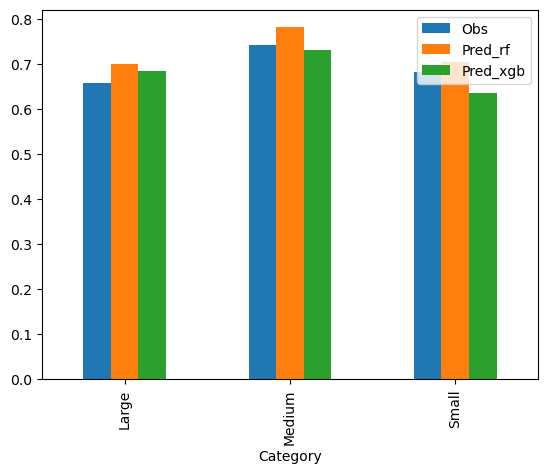

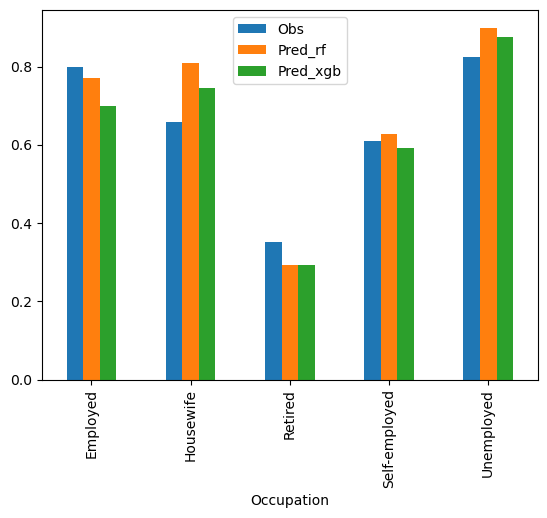

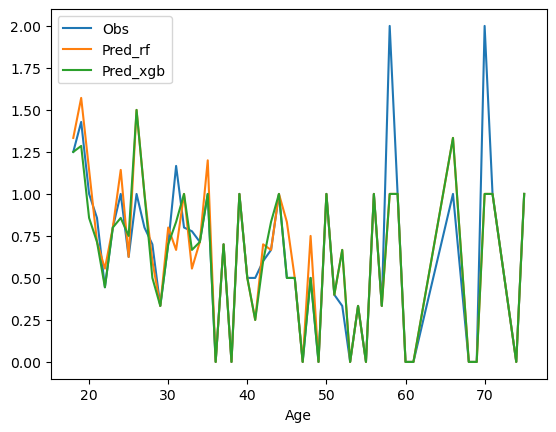

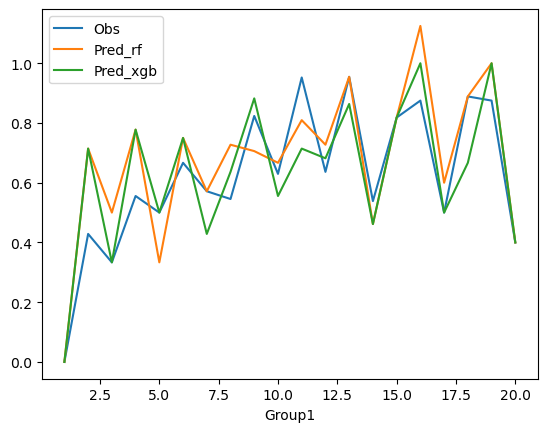

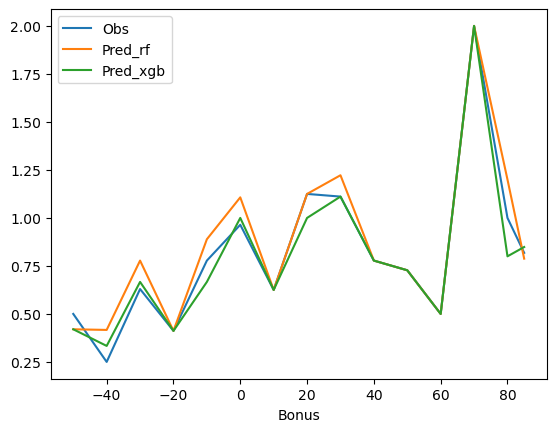

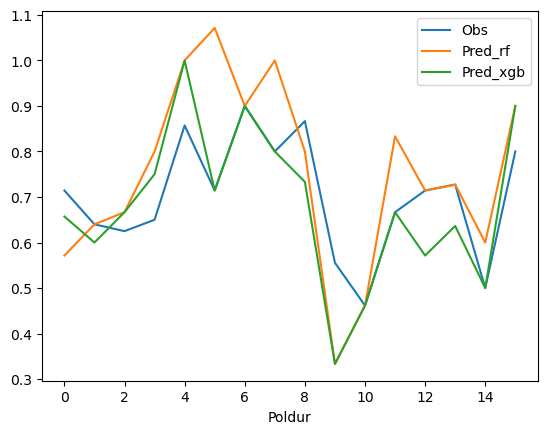

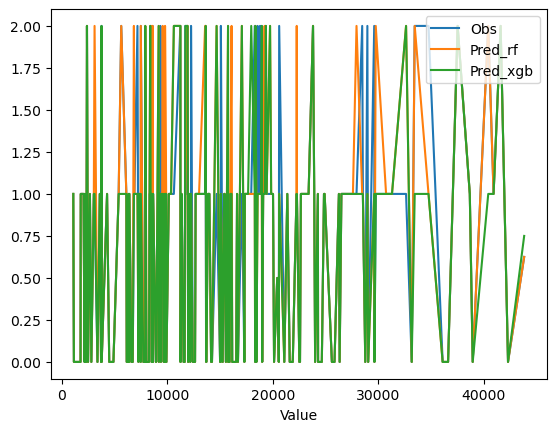

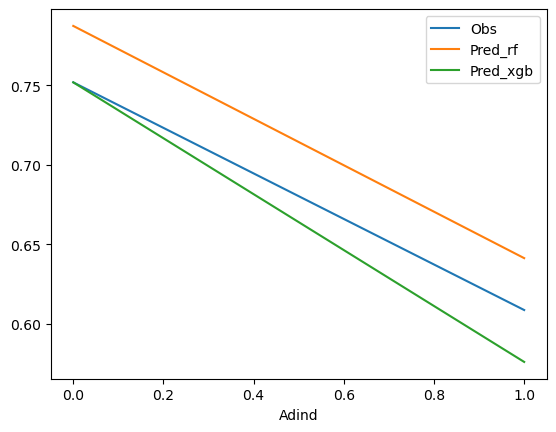

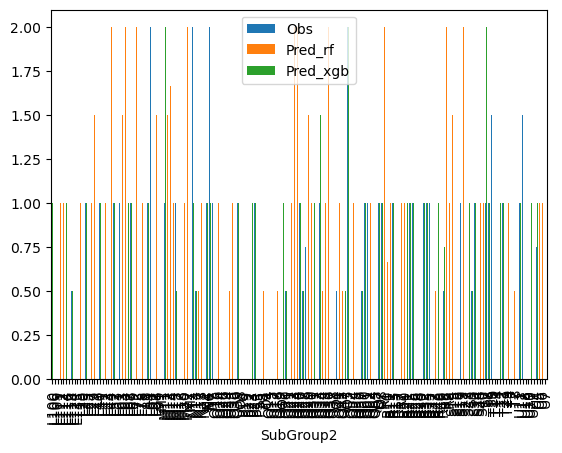

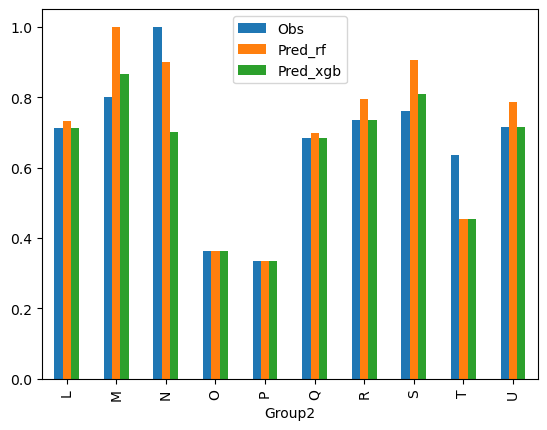

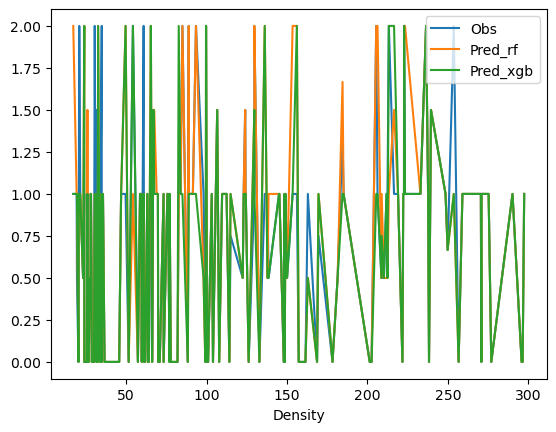

In [125]:
for var in dataFinale.columns[3:16]:
#     dataFinale.groupby([var])[['Obs', 'Pred_model', 'Pred_knn', 'Pred_tree', 'Pred_xgb']].mean().plot()
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf', 'Pred_xgb']].mean()
        
    if dataFinale[var].dtypes == 'O':
        dataPlot.plot(kind='bar')
    else:
        dataPlot.plot()

## verification dµe overfiting

In [60]:
# Vérification de la distribution des classes dans l'ensemble d'entraînement
print("Distribution des classes dans l'ensemble d'entraînement:")
print(y_train.value_counts(normalize=True))

# Vérification de la distribution des classes dans l'ensemble de test
print("Distribution des classes dans l'ensemble de test:")
print(y_test.value_counts(normalize=True))

Distribution des classes dans l'ensemble d'entraînement:
Numtpbi
0    0.431647
1    0.424112
2    0.144241
Name: proportion, dtype: float64
Distribution des classes dans l'ensemble de test:
Numtpbi
1    0.454936
0    0.424893
2    0.120172
Name: proportion, dtype: float64


### Reseau de neurone

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Générer les poids de l'échantillon en fonction de la classe
weights = y_train.map(class_weights)

# Standardiser les caractéristiques pour l'entraînement du réseau de neurones
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialiser le réseau de neurones
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=42)

# Entraîner le réseau de neurones avec des poids d'échan
# Entraînement du modèle
mlp.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_mlp = mlp.predict(X_test)

# Calcul du score F1
mlp_f1_score = f1_score(y_test, y_pred_mlp, average='macro')
print('F1 Score:', mlp_f1_score)


print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))

F1 Score: 0.5758444369798081
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        99
           1       0.69      0.58      0.63       106
           2       0.50      0.25      0.33        28

    accuracy                           0.67       233
   macro avg       0.62      0.57      0.58       233
weighted avg       0.66      0.67      0.65       233

[[88 11  0]
 [38 61  7]
 [ 4 17  7]]


/opt/mamba/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Initialiser le Perceptron avec équilibrage de classe
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42, class_weight='balanced')

# Entraîner le Perceptron
perceptron.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_per = perceptron.predict(X_test)

# Calculer le score F1
f1_score_perceptron = f1_score(y_test, y_pred_per, average='macro')

# Afficher le score F1
print('F1 Score:', f1_score_perceptron)
print(classification_report(y_test, y_pred_per))
print(confusion_matrix(y_test, y_pred_mlp))


F1 Score: 0.5157333414486859
              precision    recall  f1-score   support

           0       0.59      0.98      0.74        99
           1       0.76      0.27      0.40       106
           2       0.39      0.43      0.41        28

    accuracy                           0.59       233
   macro avg       0.58      0.56      0.52       233
weighted avg       0.65      0.59      0.55       233

[[88 11  0]
 [38 61  7]
 [ 4 17  7]]
